<img src = "https://drive.google.com/uc?export=view&id=1X3dvBPrNx6LbvsOJsYoZDOiUUwpYl-2v" alt = "Encabezado MLDS" width = "100%">  </img>

#**Reducción de la dimensionalidad**
---

En muchas tareas de análisis del mundo real el número de características a considerar es muy grande, dificultando el análisis por medio de visualización u otras tareas como el preprocesamiento o el modelado. La selección de las características es uno de los procesos de toma de decisiones más importantes en el aprendizaje automático, y en su desarrollo se han considerado técnicas de preprocesamiento que permiten reducir el número de dimensiones conservando la mayor cantidad de información posible. Este *notebook* se centra en esa necesidad y presenta la técnica de análisis de componentes principales.

# **1. Dependencias**
---
Importamos las librerías necesarias y definimos algunas funciones básicas de visualización que vamos a usar en algunos ejemplos. 


### **1.1. Dependencias**
---
Para la construcción de modelos y ejecución de procedimientos metodológicos de aprendizaje automático, utilizaremos la librería _Scikit-learn_ (**`sklearn`**) y varias de sus funciones y conjuntos de datos.

In [1]:
# Actualizamos scikit-learn a la última versión
!pip install -U scikit-learn 

# Importamos scikit-learn 
import sklearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Importamos además algunas librerías básicas y configuraciones de *Python*.

In [2]:
# Librerías básicas NumPy, Pandas, Matplotlib y Seaborn.
import numpy as np
import pandas as pd
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns

In [3]:
# Librería de visualización interactiva - Plotly
!pip install -U plotly
import plotly
import plotly.express as px
import plotly.graph_objects as go

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 15.2 MB 5.2 MB/s 
  Attempting uninstall: plotly
    Found existing installation: plotly 5.5.0
    Uninstalling plotly-5.5.0:
      Successfully uninstalled plotly-5.5.0


In [4]:
# Configuraciones para las librerías y módulos usados.

# Ignoramos las advertencias o warnings.
import warnings
warnings.simplefilter(action='ignore')

# Configuramos el formato por defecto de la 
# librería de visualización Matplotlib.
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
mpl.rcParams['figure.dpi'] = 105
mpl.rcParams['figure.figsize'] = (9, 7)
sns.set_theme()

In [5]:
# Versiones de las librerías usadas.

!python --version
print('NumPy', np.__version__)
print('Pandas', pd.__version__)
print('Matplotlib', mpl.__version__)
print('Seaborn', sns.__version__)
print('Plotly', plotly.__version__)
print('Scikit-learn', sklearn.__version__)

Python 3.7.15
NumPy 1.21.6
Pandas 1.3.5
Matplotlib 3.2.2
Seaborn 0.11.2
Plotly 5.10.0
Scikit-learn 1.0.2


Esta actividad se realizó con las siguientes versiones:
*  *Python*: 3.7.10
*  *NumPy*:  1.19.5
*  *Pandas*: 1.1.5
*  *Matplotlib*:  3.2.2
*  *Seaborn*:  0.11.1
*  *Plotly*: 4.14.3
*  *Scikit-learn*: 0.24.1

### **1.2. Funciones de utilidad y visualización**
---

Para ilustrar los ejemplos discutidos en este material utilizaremos algunas funciones que permiten visualizar de manera general los datos, junto a las funciones de predicción obtenidas con cada modelo.

> **Nota**: *Matplotlib*, *Seaborn* y *Plotly* se encuentran por fuera del alcance de este módulo. No es necesario que entienda estas funciones en detalle para sacar partido del resto del contenido puesto a su disposición. Usted decide si leer o no estas funciones en profundidad. Si decide omitir esta sección, continúe directamente con la siguiente sección, en donde se discutirán los conjuntos de datos que vamos a utilizar.

In [6]:
# Función para visualizar un conjunto de datos en 2D

def plot_data(X, y):
    y_unique = np.unique(y)
    colors = plt.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        plt.scatter(this_X[:, 0], this_X[:, 1],  color=color,
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    plt.legend(loc="best")

In [7]:
# Grafica de la proyección en 2 dimensiones obtenida con PCA.

def plot_pca(X, Xr, title = "Proyección vectorial", components = None):

  plt.figure(dpi = 110, figsize = (7,6))
  plt.title(title)
  plt.scatter(X[:,0], X[:,1], color="blue", alpha=.5, label="Datos originales")
  plt.scatter(Xr[:,0], Xr[:,1], color="red", alpha=.5, label="Datos reconstruidos")

  plt.axis('equal') 

  for i in range(len(X)):
    plt.plot([X[i, 0], Xr[i, 0]], [X[i, 1], Xr[i, 1]], ls = '--', color = '#333333')

  x_lo, x_hi = plt.xlim()
  y_lo, y_hi = plt.ylim()

  if not components is None:
    for i in range(len(components)):      
      v = components[i]
      plt.plot([-100* v[0], 0, 100* v[0]], [-100 * v[1], 0, 100 * v[1]], lw=2, ls = '--', label=f"Componente principal {i + 1}")         

  plt.ylim([-1.5, 1.5])
  plt.xlim([-1.5, 1.5])
  plt.legend(loc="center left", bbox_to_anchor=(1.01,.5));

In [8]:
# Gráfica de la varianza explicada acumulada.

def cumulative_explained_variance_plot(expl_variance):

  cum_var_exp = np.cumsum(expl_variance)

  plt.figure(dpi = 100, figsize = (8, 6))
  plt.title('Curva acumulativa de la varianza explicada VS n° de componentes principales', 
            fontdict= dict(family ='serif', size = 16))
  plt.xlabel('Número de componentes principales',
             fontdict= dict(family ='serif', size = 14))
  plt.ylabel('Varianza explicada acumulativa',
             fontdict= dict(family ='serif', size = 14))  

  nc = np.arange(1, expl_variance.shape[0] + 1)

  plt.plot(nc, cum_var_exp, '--r')
  plt.plot(nc, cum_var_exp, 'c*', ms = 5)   
  plt.show()

In [9]:
# Gráfica de las imágenes originales y reconstruidas.

def show_img_matrix_pca(X, Xr):
  plt.figure(figsize=(10,6), dpi = 105)
  for i in range(6):
    k = np.random.randint(len(X))  
        
    plt.subplot(3,6,i+1)      
    plt.imshow(Xr[k].reshape(28,28), cmap=plt.cm.Greys_r)
    plt.xticks([]); plt.yticks([])

    plt.subplot(3,6,6+i+1)
    plt.imshow(X[k].reshape(28,28), cmap=plt.cm.Greys_r)
    plt.xticks([]); plt.yticks([])

# **2. Conjuntos de datos**
---

Para los ejemplos desarrollados en el transcurso de material, se usarán datos de  *Scikit-Learn* de carácter real (usando *Loaders* y otras fuentes) y sintéticos (usando *Generators*).

### **2.1. Conjunto de datos *Wine***
---

El conjunto de datos *Wine* es uno de los más populares en el área del aprendizaje automático. Consiste en datos de un análisis químico de vinos de 3 cultivos diferentes de una región de Italia, y es comúnmente usado en tareas de clasificación. Hace parte del repositorio de *Machine Learning* de la Universidad de California en Irvine (UCI) y en este material se cargará con el método **`load_wine`** de **`sklearn.datasets`**.

In [10]:
# Conjuntos de datos - Wine
from sklearn.datasets import load_wine

wine = load_wine(return_X_y = False)

X_wine = wine.data
y_wine = wine.target

In [11]:
# Características del dataset
wine.feature_names

['alcohol',
 'malic_acid',
 'ash',
 'alcalinity_of_ash',
 'magnesium',
 'total_phenols',
 'flavanoids',
 'nonflavanoid_phenols',
 'proanthocyanins',
 'color_intensity',
 'hue',
 'od280/od315_of_diluted_wines',
 'proline']

In [12]:
# Primeras 5 observaciones de las características de Wine
pd.DataFrame(X_wine, columns = wine.feature_names).head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [13]:
# Primeras 5 observaciones de la variable objetivo.
y_wine[:5]

array([0, 0, 0, 0, 0])

In [14]:
# Conteo de cada categoría de la variable objetivo
pd.value_counts(y_wine)

1    71
0    59
2    48
dtype: int64

### **2.2. Dígitos escritos a mano MNIST**
---
El *dataset* **MNIST** es un conjunto de datos de $60000$ imágenes de dígitos escritos a mano de $28 \times 28$ píxeles. Es usada comúnmente en tareas de clasificación, donde la variable objetivo corresponde a un dígito de $0$ a $9$, y con $784$ características, que corresponden a cada píxel de la imagen. En esta ocasión, usaremos la función **`fetch_openml`** de **`sklearn.datasets`** para descargar el conjunto de datos del repositorio [OpenML.org](https://www.openml.org/d/554).

> **Nota:** la carga del conjunto de datos puede tardar cerca de un minuto.

In [15]:
#Conjuntos de datos - Repositorio OpenML
from sklearn.datasets import fetch_openml

# Descargamos el dataset desde OpenML. Este proceso puede tardar un poco.
mnist = fetch_openml('mnist_784', as_frame = False)

In [16]:
X_mnist = mnist.data
y_mnist = mnist.target

In [17]:
# Primeras 5 observaciones. 
pd.DataFrame(X_mnist, columns = mnist.feature_names).head()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Cada número corresponde a un valor entre $0$ y $255$ con la intensidad del color, representado generalmente con escala de grises:

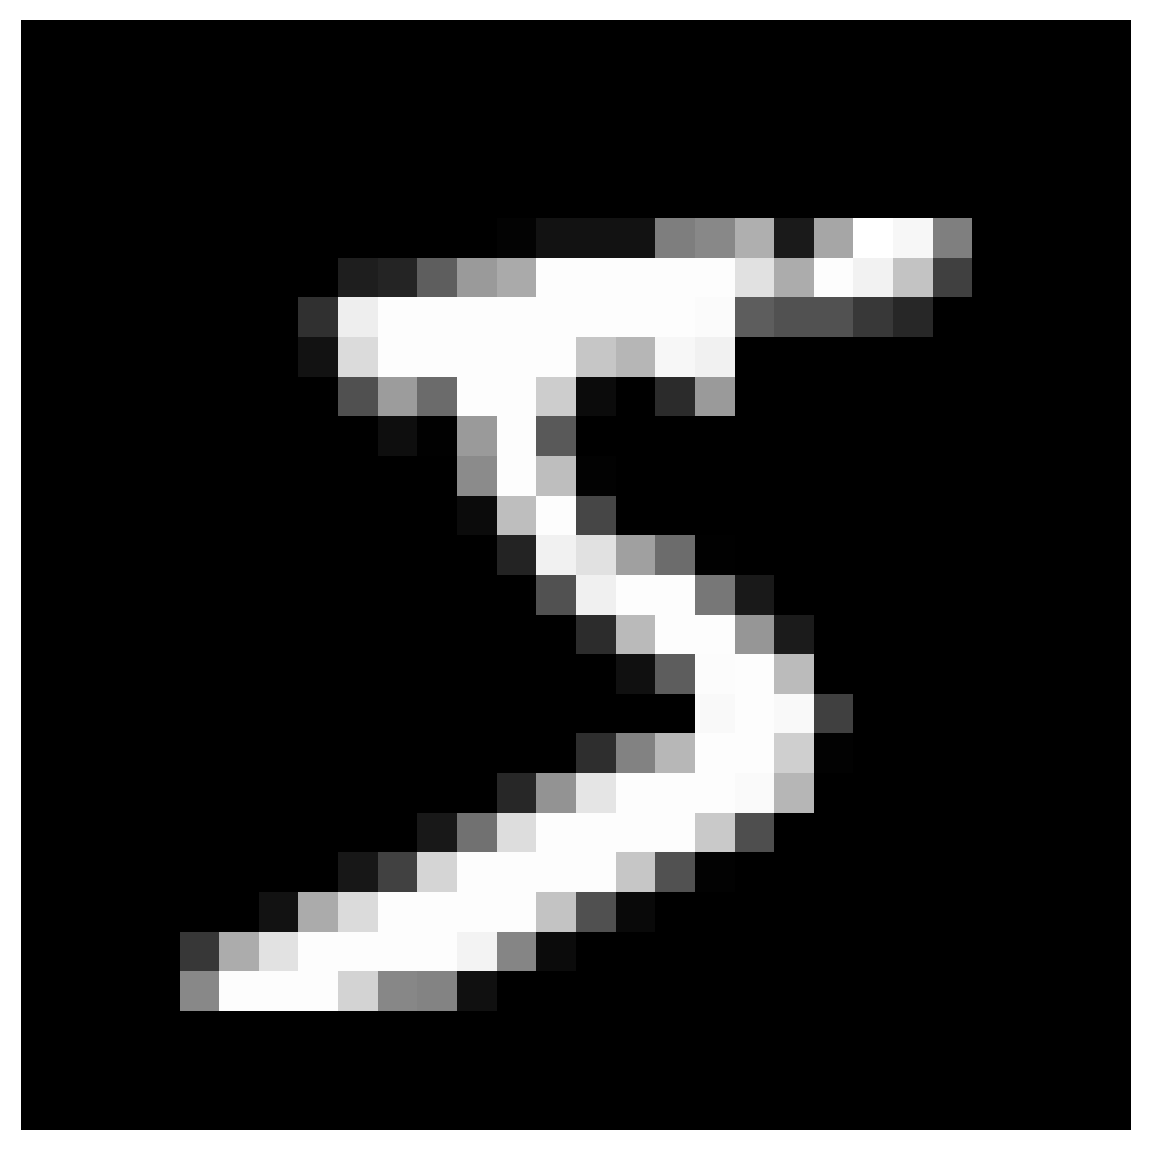

In [18]:
# Visualización de la primera imagen del dataset.
plt.axis('off')
plt.imshow(mnist.data[0].reshape(28,28), cmap = 'gray');

In [19]:
# Primeras 5 clases de la variable objetivo.
y_mnist[:5]

array(['5', '0', '4', '1', '9'], dtype=object)

In [20]:
# Conteo de la distribución de digitos
pd.value_counts(y_mnist)

1    7877
7    7293
3    7141
2    6990
9    6958
0    6903
6    6876
8    6825
4    6824
5    6313
dtype: int64

#**3. Análisis de componentes principales (PCA)** 
---

Inicialmente, consideraremos el caso en el que deseamos reducir un conjunto de datos de dos dimensiones a uno con solo una. Una alternativa es realizar una [proyección vectorial](https://matthew-brett.github.io/teaching/vector_projection.html) de nuestros datos en otro vector. La única dimensión de la nueva representación corresponderá a la magnitud del punto proyectado en la línea generada por el vector sobre el que se proyecta.
Esta idea se puede ver mejor de forma gráfica. A continuación, creamos unos datos 2D de manera aleatoria.


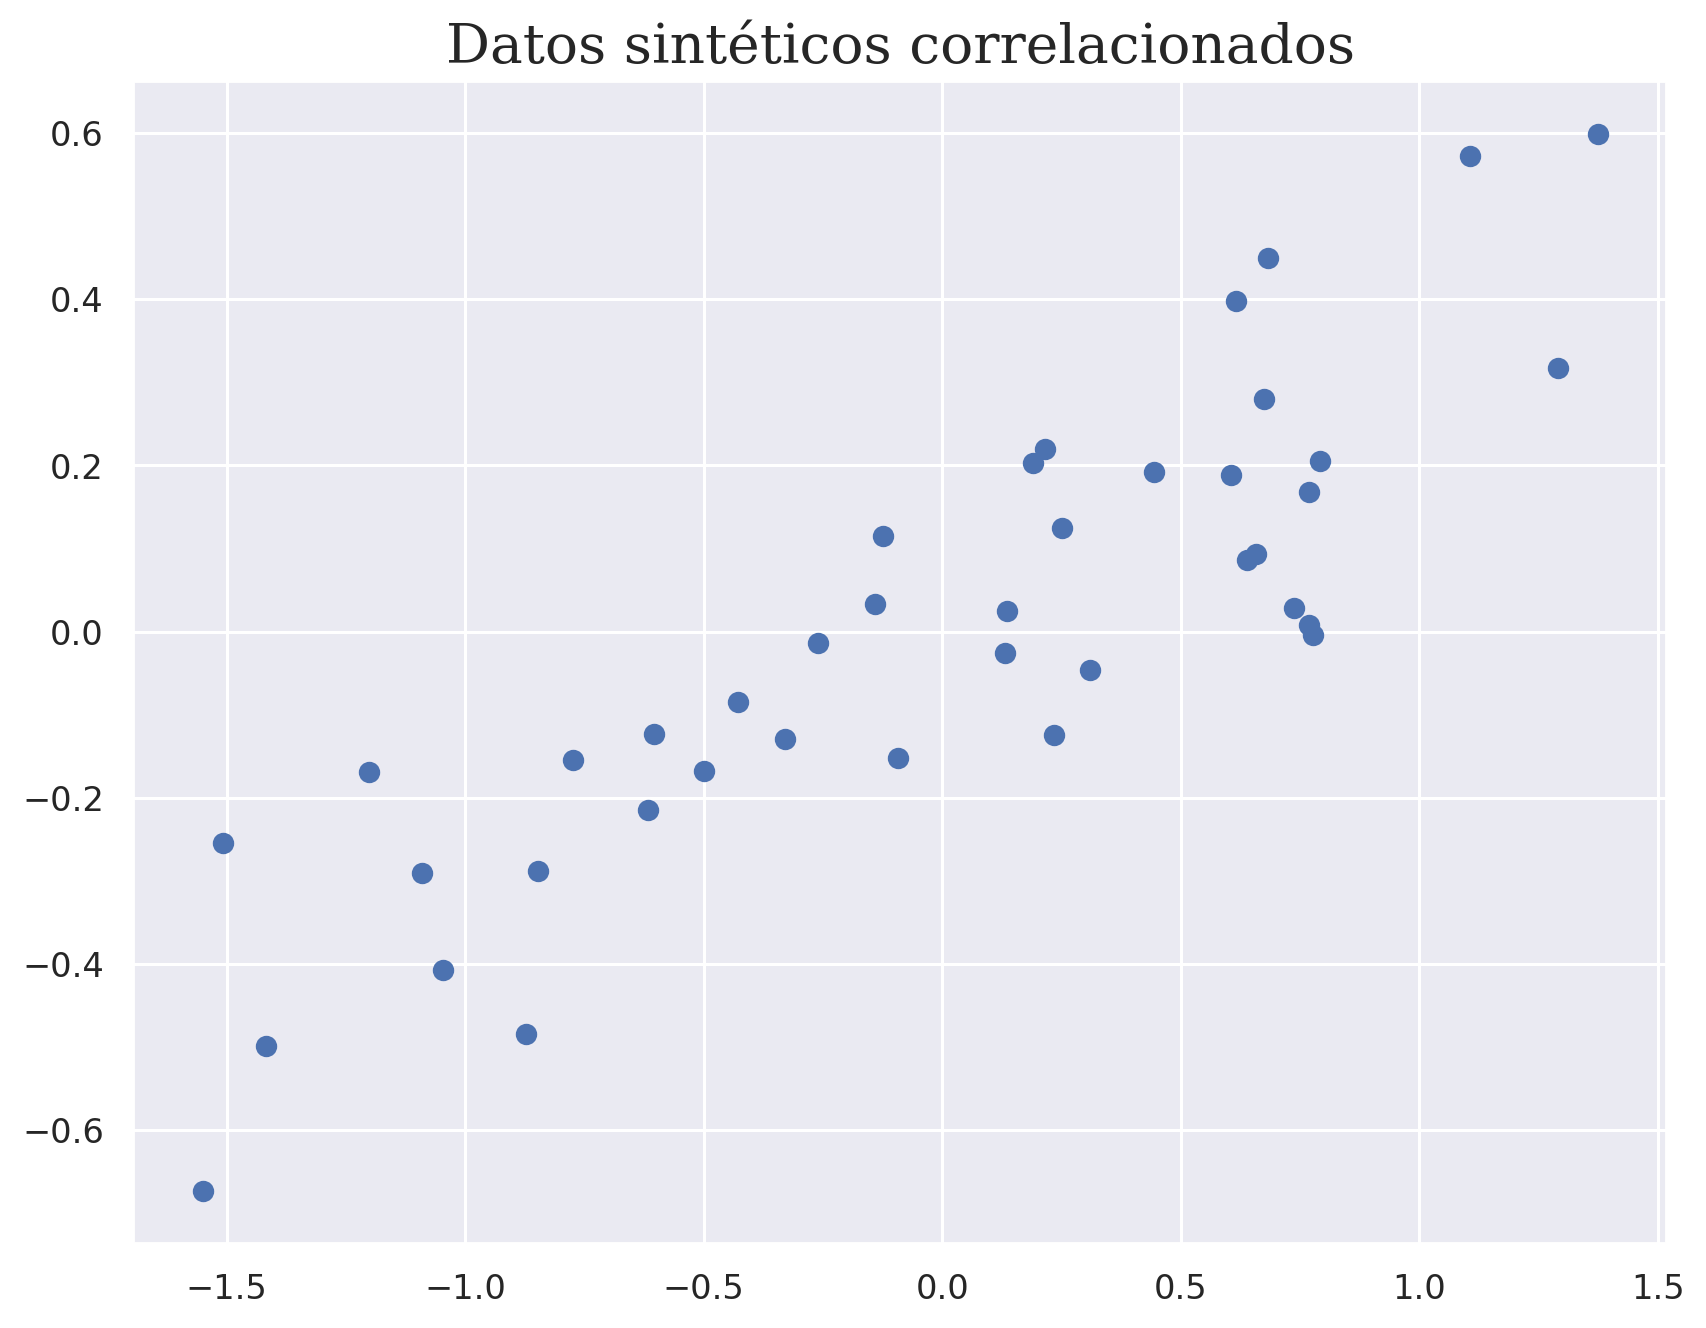

In [21]:
# Creación de los datos sintéticos de ejemplo.

# Semilla aleatoria.
np.random.seed(1) 

# Datos sintéticos correlacionados.
X = np.dot(np.random.random(size=(2, 2)),
           np.random.normal(size=(2, 40))).T + 10 

# Centramos los datos en 0,0
X = X - np.mean(X, axis=0)

plt.figure(dpi = 110)
plt.title('Datos sintéticos correlacionados', fontdict = dict(family = 'serif', size = 18))
plt.scatter(X[:,0], X[:,1]);

En álgebra lineal, la proyección $proj_\vec{v} \vec{x}$ de un vector $\vec{x}$ en otro vector $\vec{v}$ se puede obtener mediante operaciones vectoriales:
 
$$proj_\vec{v} \vec{x} = c \vec{v}$$

con $c$ igual a:

$$c = \frac{\vec{v}\cdot \vec{x}}{||\vec{v}||^2}$$


$c$ es un escalar que refleja el punto de la proyección de $\vec{x}$ sobre $\vec{v}$. Este valor se puede interpretar como una representación de 1 dimensión sobre el vector $\vec{v}$.

Vamos a inspeccionar gráficamente algunas posibles proyecciones:

In [22]:
#@title 
#@markdown **Animación:** Ejecute esta celda para ver un ejemplo de proyección de un conjunto de datos de 2 dimensiones a un vector de 1 dimensión, con un registro de la varianza del vector resultante. Oprima el botón **'Reproducir'** para iniciar la animación.
def unit_vector(angle):
  return np.array([np.cos(angle), np.sin(angle)])

n = 120
angles = np.linspace(0, np.pi, n)
projs = []

frames_data = []
for i in range(n):
    angle = angles[i] # Ángulo entre 0 y pi.
    v = unit_vector(angle) # Vector sobre el cual se realizará la proyección.
    c = X.dot(v.reshape(-1,1))/(np.linalg.norm(v)**2) # Se calcula c con operación vectoriales de NumPy.
    Xp = c * v # Valor en dos dimensiones con la posición de la proyección del vector.    
    frames_data.append( (Xp, angle, v, c))


Xp0, angle0, v0, c0 = frames_data[0]

fig = go.Figure(
    data = [
        go.Scatter(x = [-10* v0[0], 10* v0[0]], y = [-10 * v0[1], 10 * v0[1]], name = 'Vector de proyección', marker = dict(color = 'black'),                   
                   text = angle0),  
        go.Scatter(x = [ -1.25], y = [ 0.75], text = f"<b>Ángulo:</b> {angle0:.4f}", textfont = dict(size = 20), textposition = 'top right',
                   showlegend= False, mode = 'text'),              
        go.Scatter(x = [ -1.25], y = [ 0.65], text = f"<b>Varianza de la proyección:</b> = {np.var(c0):.4f}", textposition = 'top right',
                   textfont = dict(size = 20), showlegend= False, mode = 'text'),    
            *[go.Scatter(x = [X[i, 0], Xp0[i, 0]], y = [X[i, 1], Xp0[i, 1]], line = dict(dash = 'dash'), showlegend= False,
                         marker = dict(color = 'grey')) for i in range(len(X))],            
        go.Scatter(x = X[:,0], y= X[:,1], mode = 'markers', name = 'Datos originales', marker = dict(color = 'blue')),
        go.Scatter(x = Xp0[:,0], y= Xp0[:,1], mode = 'markers', name = 'Datos reconstruidos', marker = dict(color = 'red'))
        ],

    layout= go.Layout(
        height = 700,
        width = 900,
        xaxis=dict(range=[-2, 2], autorange=False),
        yaxis=dict(range=[-1, 1], autorange=False),
        title= dict(text = "<b>Varianza de las posibles proyecciones vectoriales</b>", font = dict(size = 25), xanchor = 'left'),
        updatemenus=[dict(            
            type="buttons",
            buttons=[dict(label="Reproducir",                         
                          method="animate",
                          args=[None,  dict(frame = dict(duration = 50, redraw = False))]
                          )])]
    ), 
    frames  = [go.Frame(
        data = [
        go.Scatter(x = [-10* v[0], 10* v[0]], y = [-10 * v[1], 10 * v[1]], name = 'Vector de proyección', marker = dict(color = 'black')),        
        go.Scatter(x = [ -1.25], y = [ 0.75], text = f"<b>Ángulo:</b> {angle:.4f}", textfont = dict(size = 20),
                   textposition = 'top right',
                   showlegend= False, mode = 'text'),
        go.Scatter(x = [ -1.25], y = [ 0.65], text = f"<b>Varianza de la proyección:</b> = {np.var(c):.4f}", textposition = 'top right',
                   textfont = dict(size = 20), showlegend= False, mode = 'text'),    
                *[go.Scatter(x = [X[i, 0], Xp[i, 0]], y = [X[i, 1], Xp[i, 1]], line = dict(dash = 'dash'), showlegend= False,
                             marker = dict(color = 'grey')) for i in range(len(X))],            
        go.Scatter(x = X[:,0], y= X[:,1], mode = 'markers', name = 'Datos originales', marker = dict(color = 'blue')),
        go.Scatter(x = Xp[:,0], y= Xp[:,1], mode = 'markers', name = 'Datos reconstruidos', marker = dict(color = 'red'))
                ]) for Xp, angle, v, c in frames_data]
)

fig.show()


Ahora note que las proyecciones que permiten distinguir más entre observaciones de los datos originales y que más se ajustan a ellos son las que tienen mayor **variabilidad o varianza**. Por lo general, queremos encontrar una proyección con menos dimensiones que preserve la máxima cantidad de variabilidad. Este es la idea detrás de la técnica **PCA**.

## **3.1. Análisis de componentes principales**
---
El **análisis de componentes principales** (llamado comúnmente por sus siglas en inglés [PCA](https://es.wikipedia.org/wiki/An%C3%A1lisis_de_componentes_principales)) es una técnica utilizada para describir un conjunto de datos en términos de nuevas variables (componentes) no correlacionadas. Las componentes son ordenadas por la cantidad de varianza original que son capaces de describir y es útil para reducir la dimensionalidad de un conjunto de datos.

La técnica *PCA* busca la proyección según la cual los datos queden mejor representados en términos de mínimos cuadrados, y convierte un conjunto de observaciones de variables posiblemente correlacionadas en un conjunto de valores de variables sin correlación lineal llamadas componentes principales. Esta técnica se emplea principalmente en el análisis exploratorio de datos y en la construcción de modelos predictivos.

**Limitaciones:**
  * Se asume que los datos observados son combinación lineal de una cierta base.
  * *PCA* utiliza los vectores propios de la matriz de covarianzas y sólo encuentra las direcciones de ejes en el espacio de variables considerando que los datos tienen una distribución normal.

<center><img src = "https://blog-c7ff.kxcdn.com/blog/wp-content/uploads/2018/07/pca.gif" alt = "PCA" width = "70%">  </img></center>


*Scikit-Learn* permite aplicar un algoritmo de *PCA* sobre un conjunto de datos mediante la función **`sklearn.decomposition.PCA`**. Esta recibe el argumento **`n_components`** que define la dimensión de la nueva representación.

Al igual que con otros estimadores y modelos de **`sklearn`**, este objeto cuenta con la función **`.fit()`** para ingresar los datos que se desean descomponer con PCA.

In [23]:
# Análisis de componentes principales (PCA)
from sklearn.decomposition import PCA

pca = PCA(n_components=1) 
pca.fit(X)

PCA(n_components=1)

Para nuestro ejemplo, podemos usar el componente mayor para reducir la dimensionalidad de nuestros datos de $2$ dimensiones a solamente $1$.

Observe que:

$$\mathbf{X_t} = \mathbf{X} \cdot \mathbf{V_c}$$

donde:
- $\mathbf{X}$ son nuestros datos
- $\mathbf{V_c}$ es el vector de componentes seleccionados
- $\mathbf{X_t}$ son los datos transformados

En este caso nos estamos restringiendo a **transformaciones lineales**, es decir, rotaciones y escalado. Para realizar este proceso con *Scikit-Learn* utilizamos el método **`.transform()`**.


In [24]:
# Transformación de los datos originales en la proyección de menor dimensión.
Xt = pca.transform(X)

# Datos con una dimensión (característica) menos.
print(X.shape, Xt.shape) 

(40, 2) (40, 1)


Es muy común que los datos usados en la obtención de los componentes (usando del método **`fit`**) sean los mismos que queramos transformar a una dimensión menor. Este proceso se puede realizar en un solo paso utilizando el método **`fit_transform`** de **`PCA`**.

In [25]:
pca = PCA(n_components= 1)
Xft = pca.fit_transform(X)

# Datos con una dimensión menos. Igual que usar fit y después transform.
Xft.shape  

(40, 1)

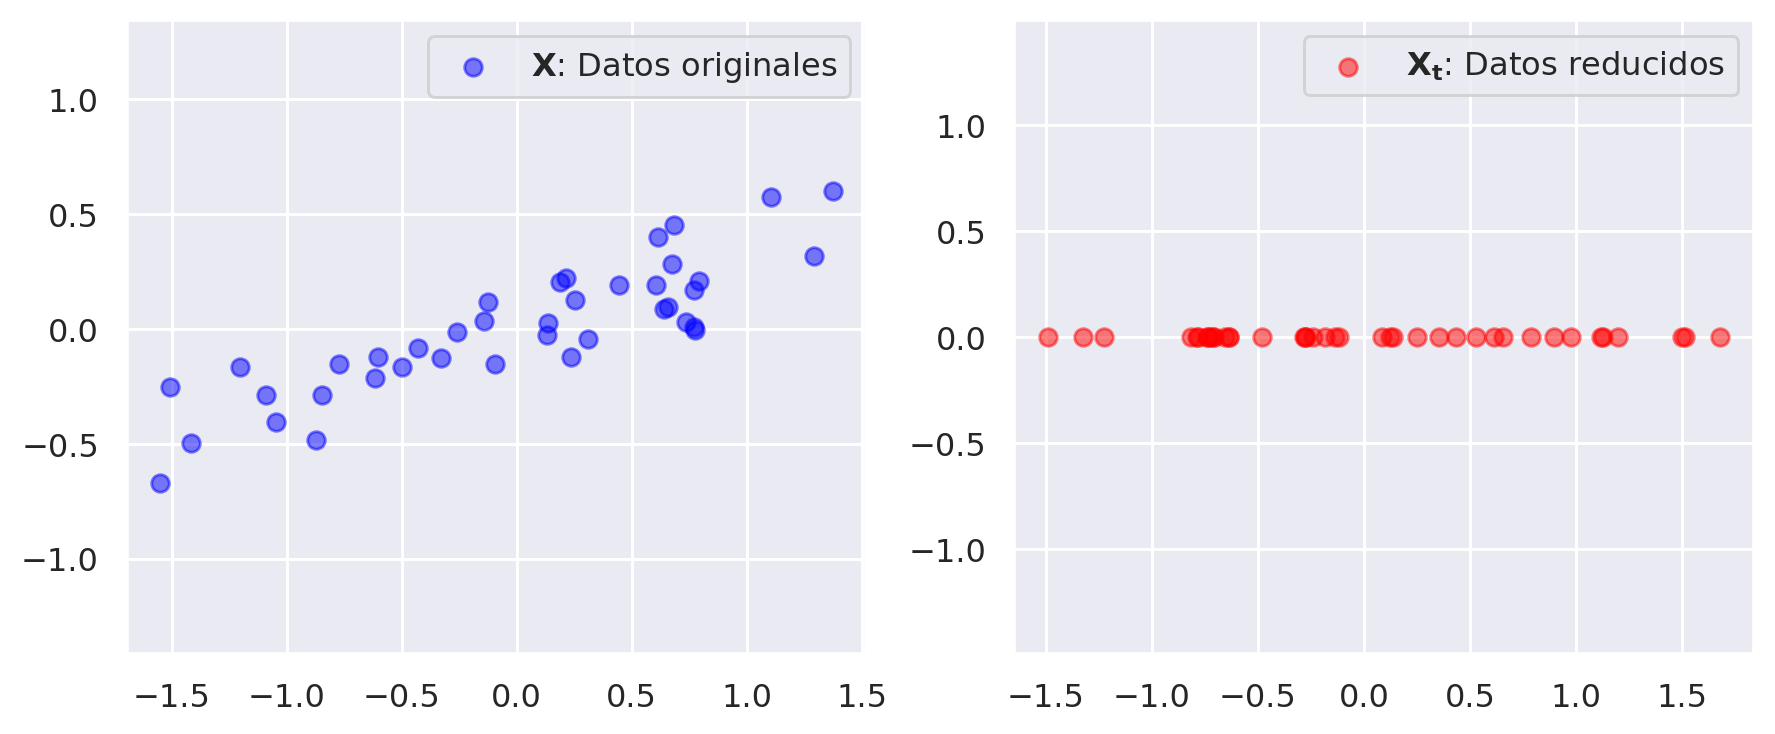

In [26]:
plt.figure(dpi = 105, figsize = (10,4))

# Datos originales

plt.subplot(1,2,1)
plt.scatter(X[:,0], X[:,1], color="blue", alpha=.5, label="$\mathbf{X}$: Datos originales"); 
plt.axis("equal"); plt.legend();

# Datos reducidos
plt.subplot(1,2,2)
plt.scatter(Xft, np.zeros(len(Xft)), color="red", alpha=.5, label="$\mathbf{X_t}$: Datos reducidos"); 
plt.axis("equal"); plt.legend();

También podemos reconstruir los datos a la dimensión original a partir de datos obtenidos mediante una transformación. 

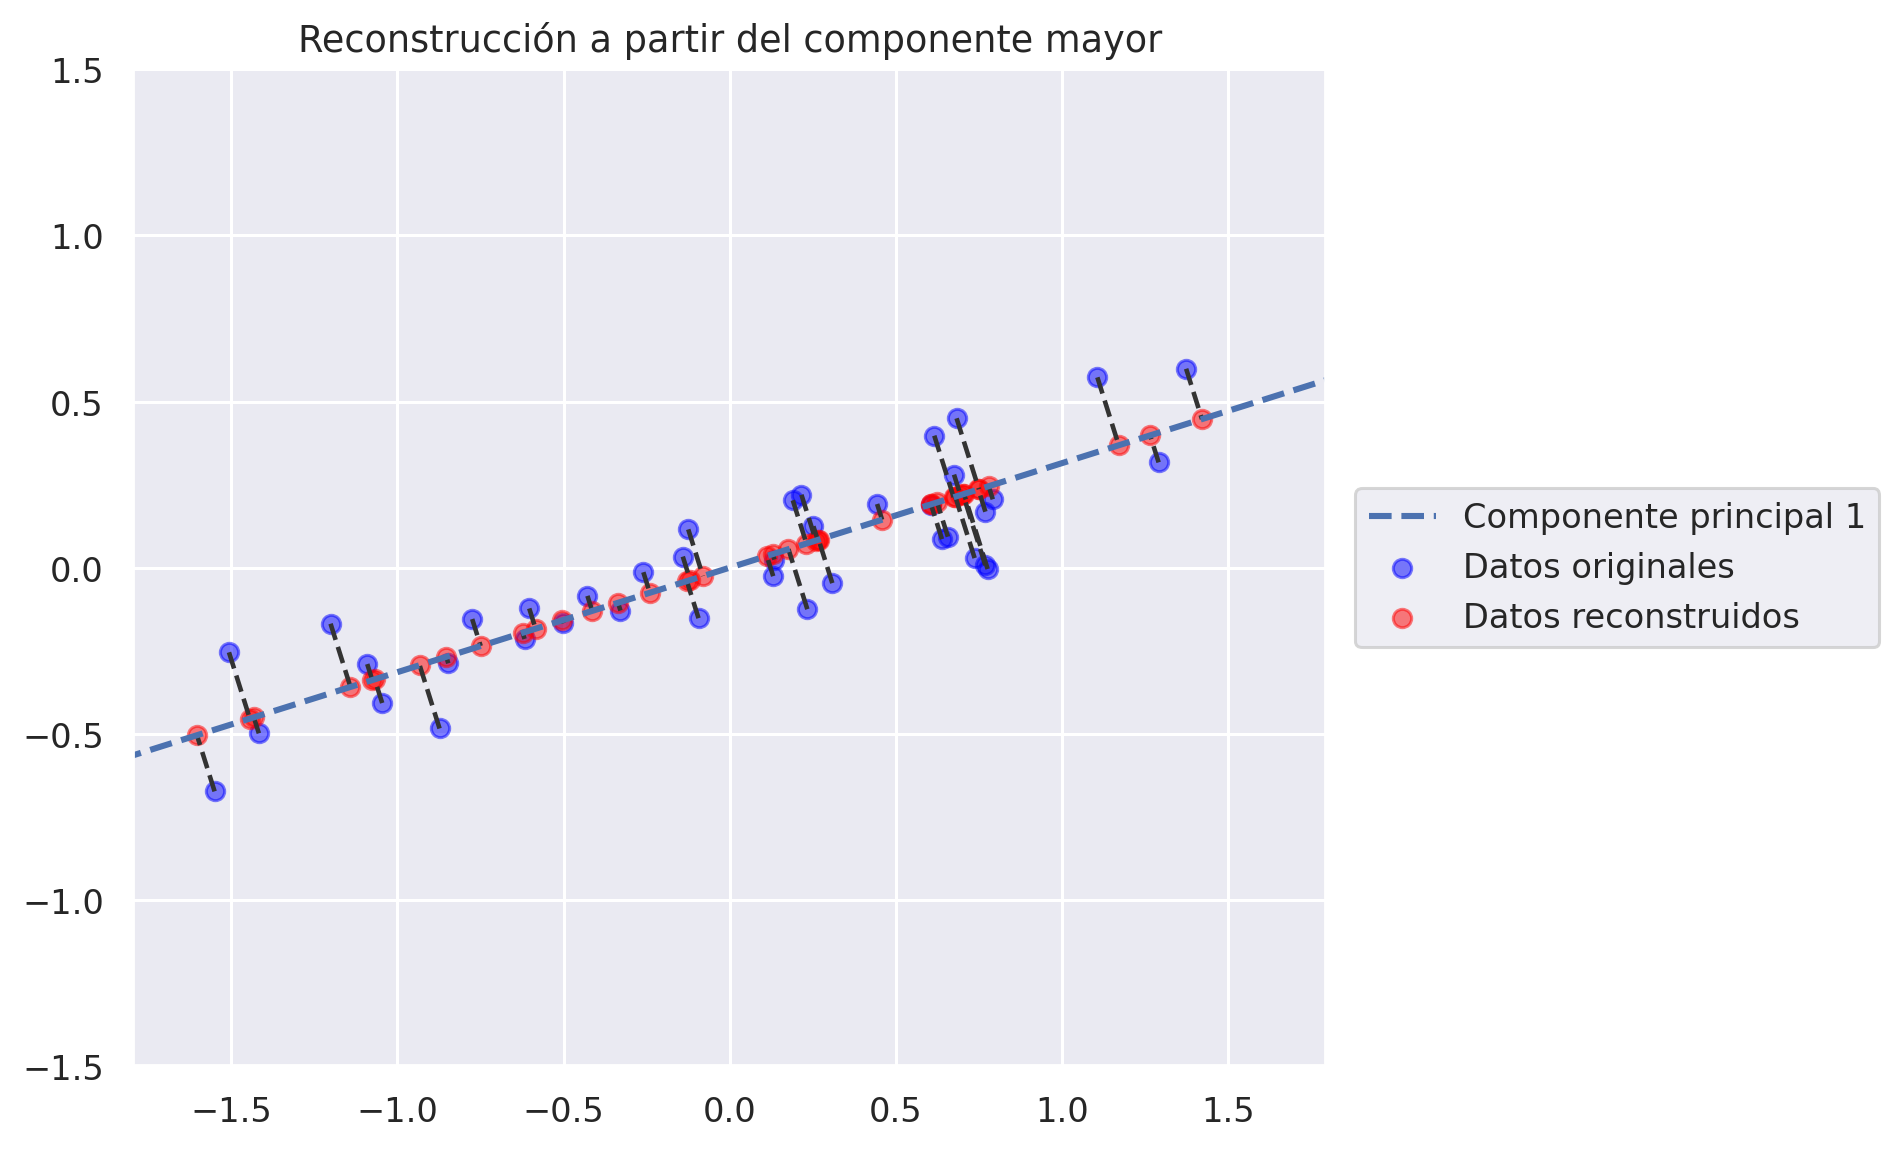

In [27]:
Xr = pca.inverse_transform(Xt)

plot_pca(X, Xr, 
         title = "Reconstrucción a partir del componente mayor", 
         components = pca.components_)

Con el atributo **`components_`** podemos acceder a los vectores de los componentes principales obtenidos con PCA. Obtengamos $2$ componentes principales y veamos su representación gráfica.

In [28]:
pca = PCA(n_components= 2)
Xp = pca.fit_transform(X)
Xr = pca.inverse_transform(Xp)

pca.components_

array([[-0.95392135, -0.30005674],
       [ 0.30005674, -0.95392135]])

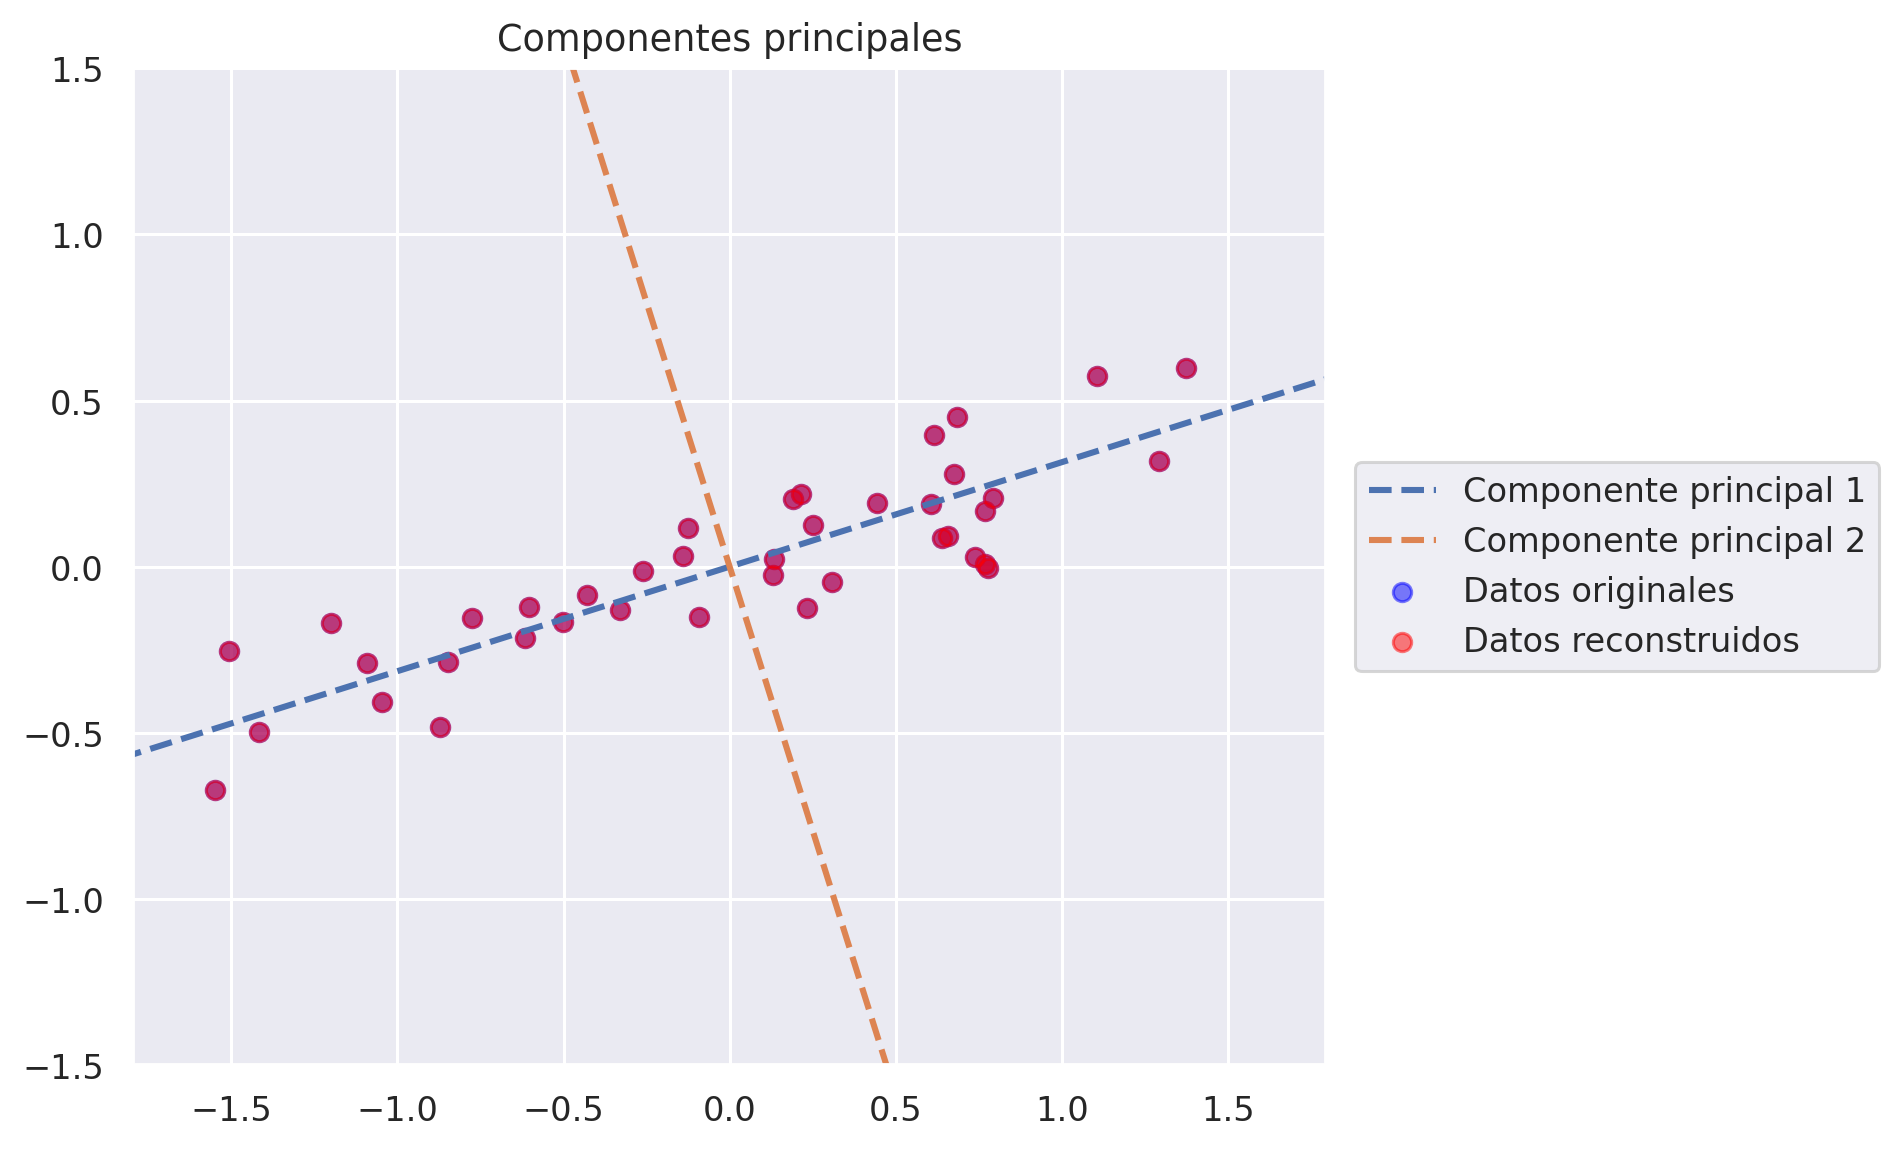

In [29]:
# Representamos con vectores los componentes principales.
plot_pca(X, 
         Xr, 
         title = "Componentes principales", 
         components = pca.components_)

##**3.2. Varianza explicada para las componentes principales**
---

En *PCA*, la varianza total es la suma de las varianzas de todos los componentes principales individuales.
Entonces, la **proporción de varianza explicada** por un componente principal es la relación entre la varianza de ese componente principal y la varianza total.
Por otro lado, si se quiere conocer el porcentaje de varianza total de varios componentes principales se puede obtener con la suma de sus varianzas y entre la varianza total.

Esto se hace generalmente con los componentes ordenados por mayor varianza explicada y se representa gráficamente con una gráfica de líneas con la **varianza explicada acumulada**.

In [30]:
pca = PCA(n_components = 2)
Xt = pca.fit_transform(X)

La varianza explicada se obtiene del atributo  **`explained_variance_ratio_`**:

In [31]:
pca.explained_variance_ratio_

array([0.97571696, 0.02428304])

El resultado indica que el primer componente explica el $97.6\%$ de la varianza y el segundo componente el $2.4\%$ restante.

En este caso, realizar la gráfica de la varianza acumulada no tiene mucho sentido pues solo contamos con dos columnas. Veamos la aplicación de PCA en un contexto real. Primero, cargamos el conjunto de datos ***Wine***:

In [32]:
wine = load_wine()

labels = wine.target
classes = wine.target_names

wine_df = pd.DataFrame(wine.data, columns = wine.feature_names)
wine_df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0


In [33]:
# HCQZ
# Preprocesamiento (Reescalado estándar)
from sklearn.preprocessing import StandardScaler

sc_x = StandardScaler()
sc_x.fit(wine.data)
X_scaled = sc_x.transform(wine.data)

In [34]:
X_scaled.shape

(178, 13)

Ahora, realizamos un escalado de los datos, con media en 0 y varianza en 1. Esto se puede realizar con el método **`sklearn.preprocessing.StandardScaler`**.

In [35]:
# Preprocesamiento (Reescalado estándar)
from sklearn.preprocessing import StandardScaler

sc_x = StandardScaler()
sc_x.fit(wine_df.values)
X_scaled = sc_x.transform(wine_df.values)

In [36]:
X_scaled.shape

(178, 13)

Analizando la varianza explicada de las componentes principales obtenemos lo siguiente:

In [37]:
# Si no se indica el número de componentes se usa la cantidad de columnas.
pca = PCA() 
transf = pca.fit_transform(X_scaled)

varianza_expl = pca.explained_variance_ratio_

print(varianza_expl)

[0.36198848 0.1920749  0.11123631 0.0706903  0.06563294 0.04935823
 0.04238679 0.02680749 0.02222153 0.01930019 0.01736836 0.01298233
 0.00795215]


A continuación, graficamos la curva acumulativa de la varianza explicada versus el número de componentes principales.

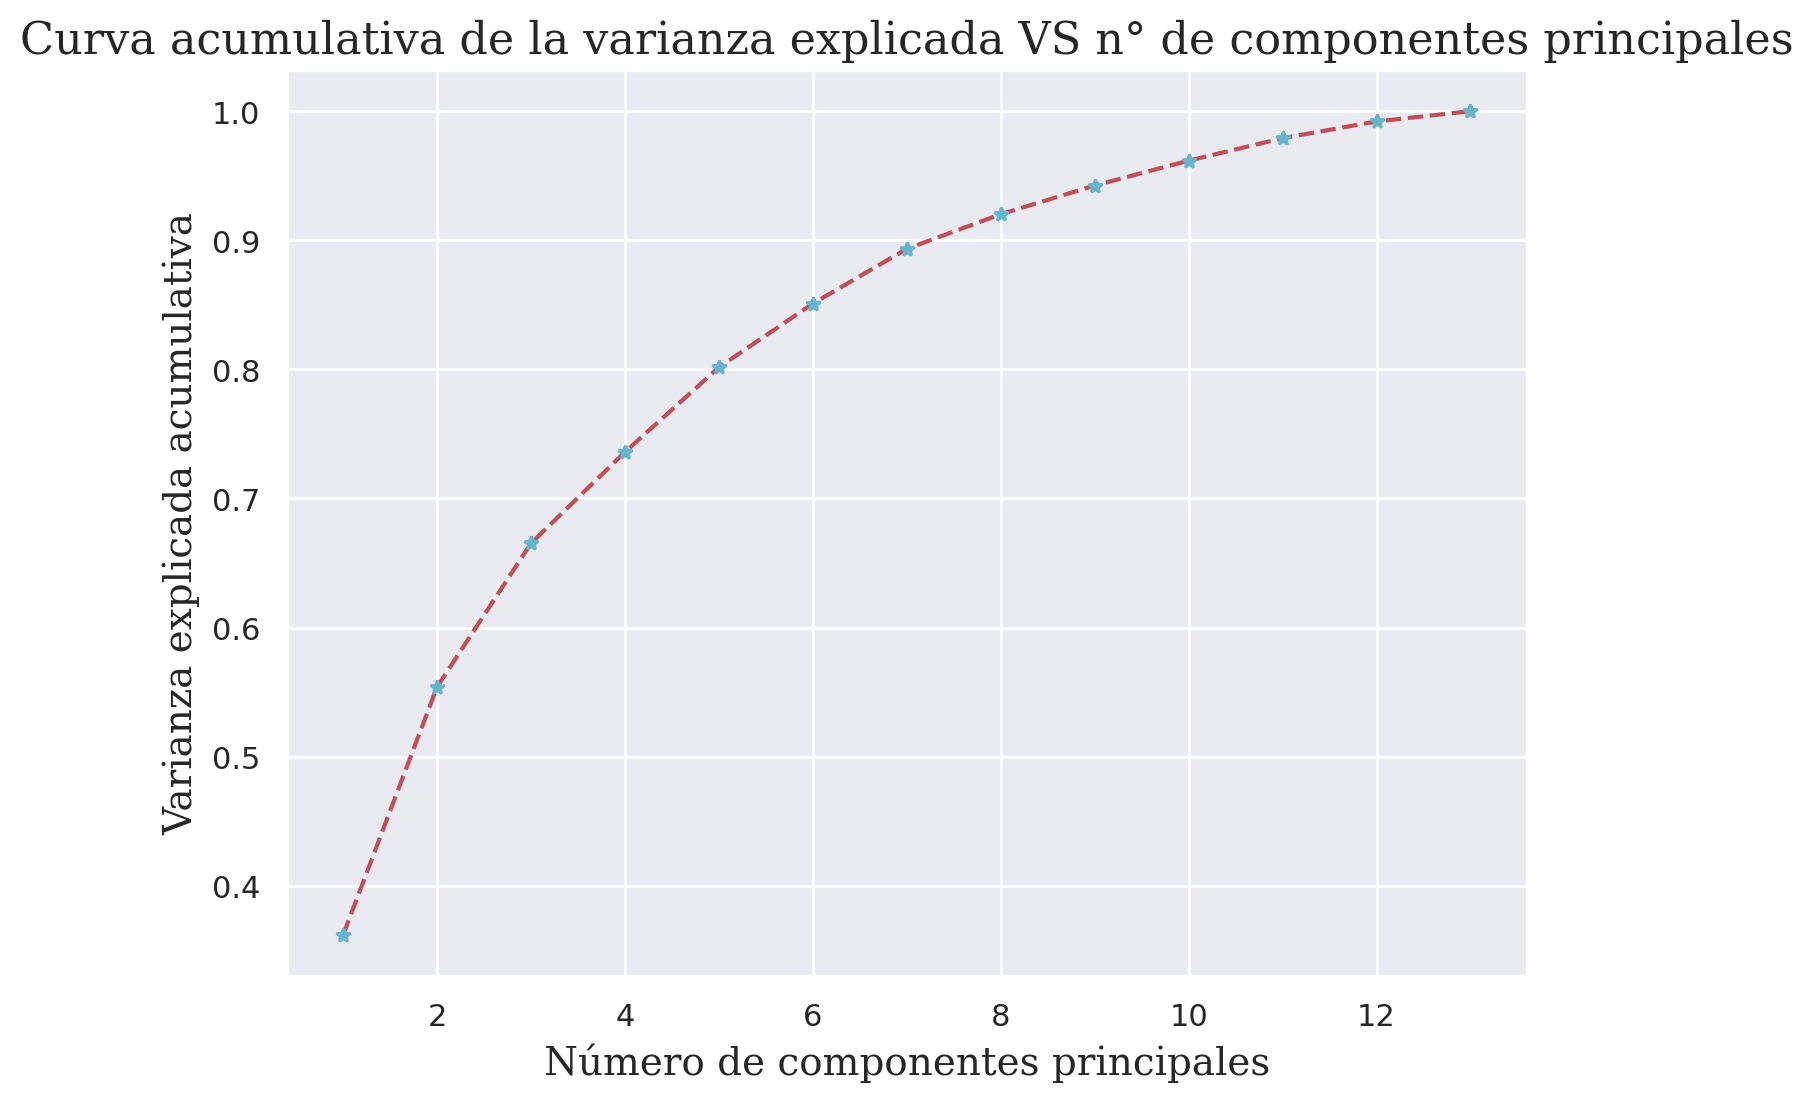

In [38]:
cumulative_explained_variance_plot(varianza_expl)

Podemos observar lo siguiente:
  * Las componentes principales $1$ y $2$ representan el $55,4\%$ de la varianza de los datos
  * Las $7$ primeras componentes principales representan el $89,3\%$ de la varianza de los datos

Podemos usar los componentes principales $1$ y $2$ para visualizar el conjunto de datos en $2$ dimensiones. Para hacer esto usamos el comando **`sklearn_pca.fit_transform`**:

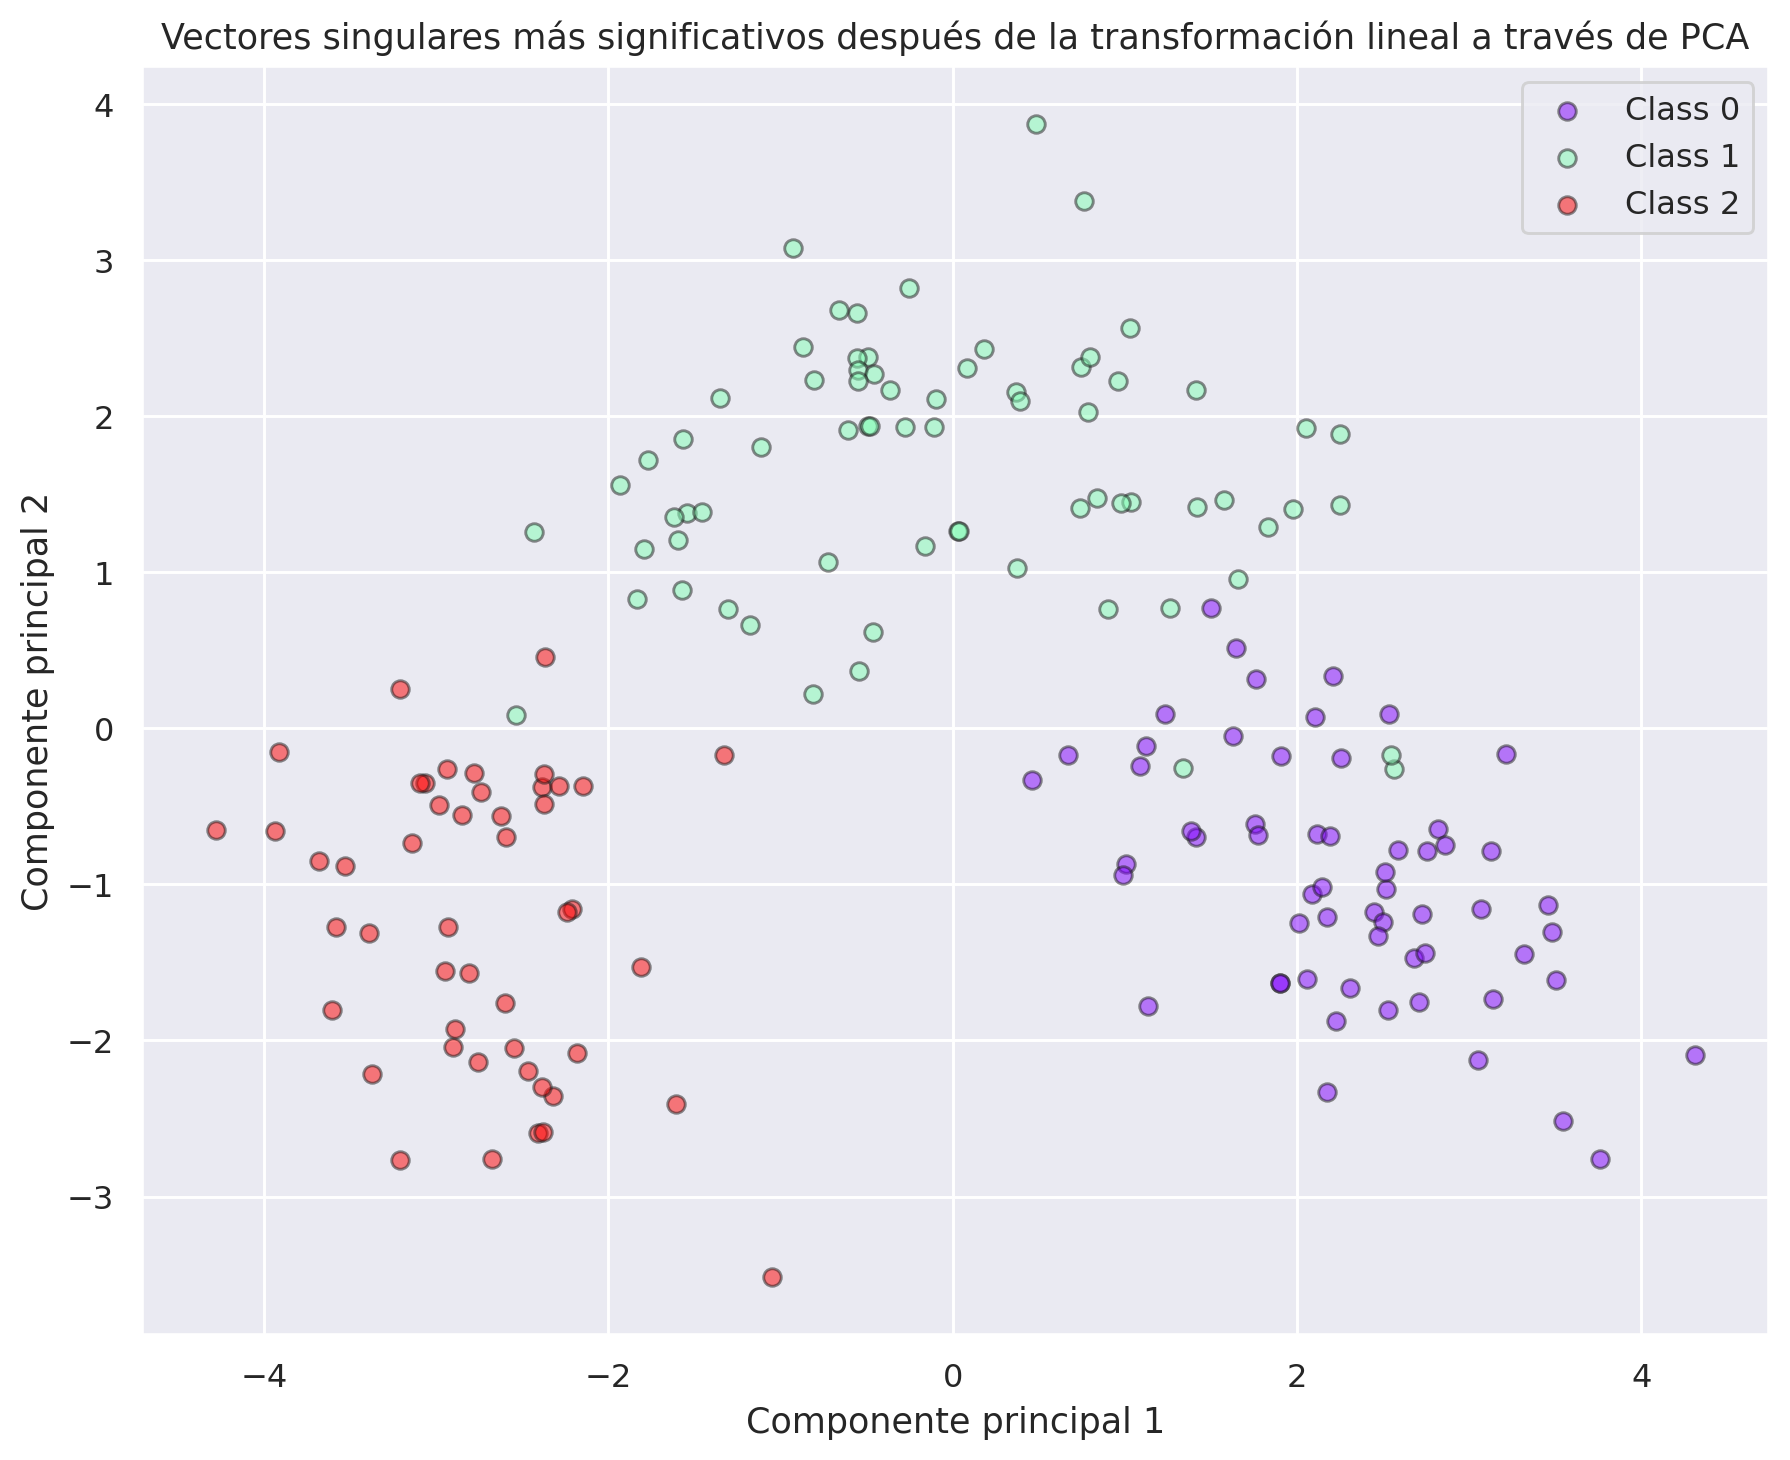

In [39]:
pca = PCA(n_components=2)
X_transf = pca.fit_transform(X_scaled)

plt.figure(figsize = (10, 8), dpi = 105)
plt.xlabel('Componente principal 1')
plt.ylabel('Componente principal 2')
plt.title('Vectores singulares más significativos después de la transformación lineal a través de PCA')

plot_data(X_transf, labels)

A pesar de ser un *dataset* de $13$ características, somos capaces de distinguir sus valores de forma gráfica en $2$ dimensiones usando sus componentes principales. Al ser los dos componentes más importantes, su visualización es la que contiene mayor varianza y es más fácil de distinguir entre sus observaciones. Ahora, consideremos una gráfica con los componentes principales $2$ y $3$.

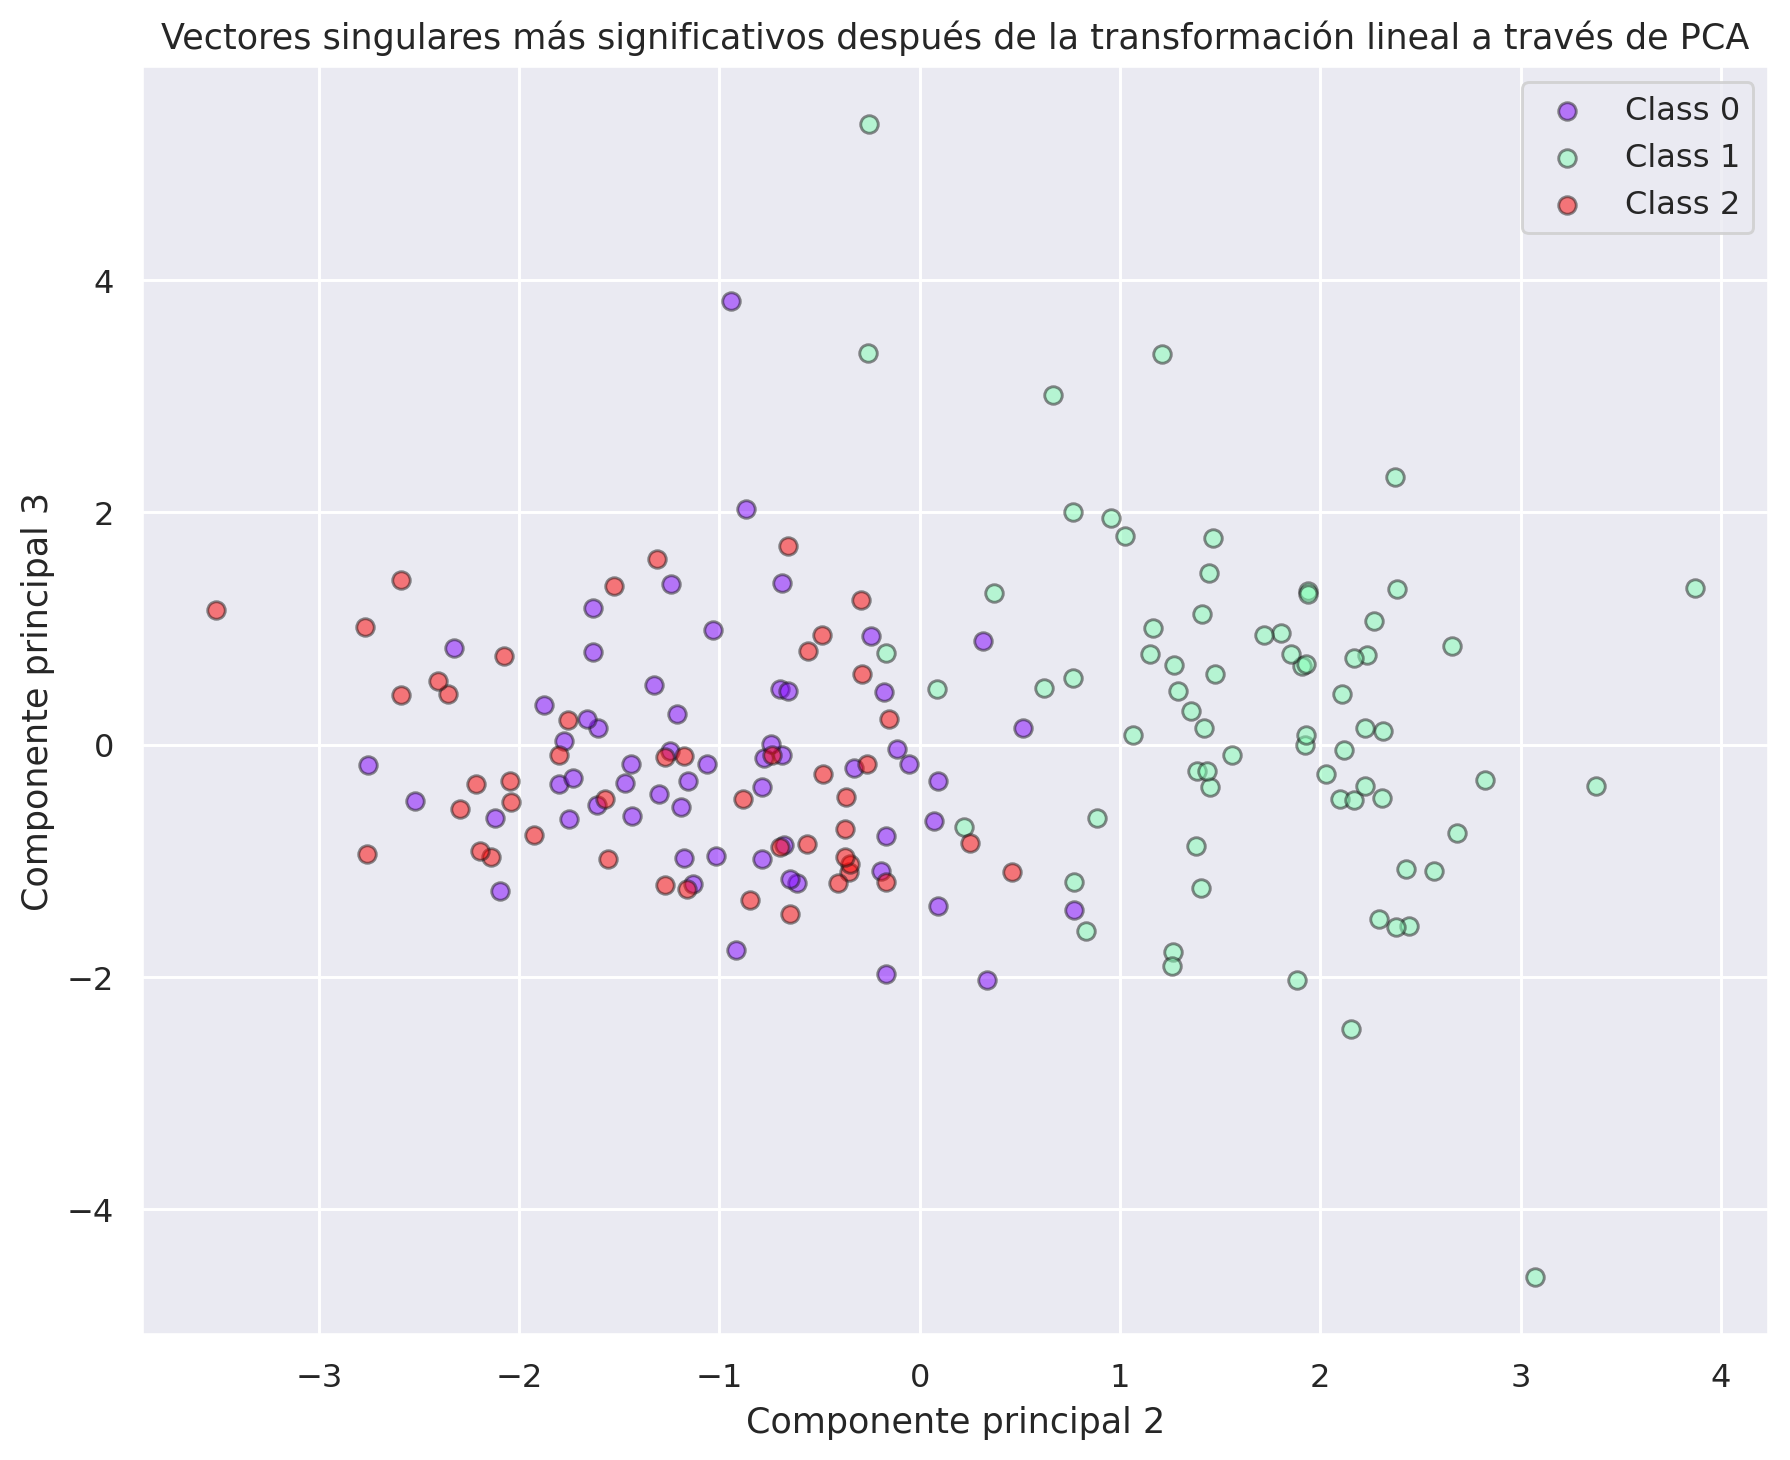

In [40]:
pca = PCA(n_components=3)
X_transf = pca.fit_transform(X_scaled)

plt.figure(figsize = (10, 8), dpi = 105)
plt.xlabel('Componente principal 2')
plt.ylabel('Componente principal 3')
plt.title('Vectores singulares más significativos después de la transformación lineal a través de PCA')
plot_data(X_transf[:,1:3],labels)

# **4. Aplicación en clasificación**
---
Ahora, veremos la aplicación de este método de reducción de la dimensionalidad en tareas de modelado como clasificación y agrupamiento, usando como datos de entrenamiento la representación obtenida con PCA. 
> **¿Qué tan conveniente es este acercamiento al problema?**

En esta parte trabajaremos con una muestra del conjunto de imágenes de **MNIST** que contiene únicamente $1500$ imágenes de dígitos escritos a mano. Aplicaremos reducción de dimensionalidad y usaremos los datos reducidos con esta herramienta en tareas de clasificación.

In [41]:
X_mnist = mnist.data[:1500]
y_mnist = mnist.target[:1500]
print("Dimensión de las imágenes y las clases: ", X_mnist.shape, y_mnist.shape)

Dimensión de las imágenes y las clases:  (1500, 784) (1500,)


Visualicemos una muestra aleatoria de imágenes del *dataset* con el método de visualización de imágenes de *Matplotlib* **`imshow`**.

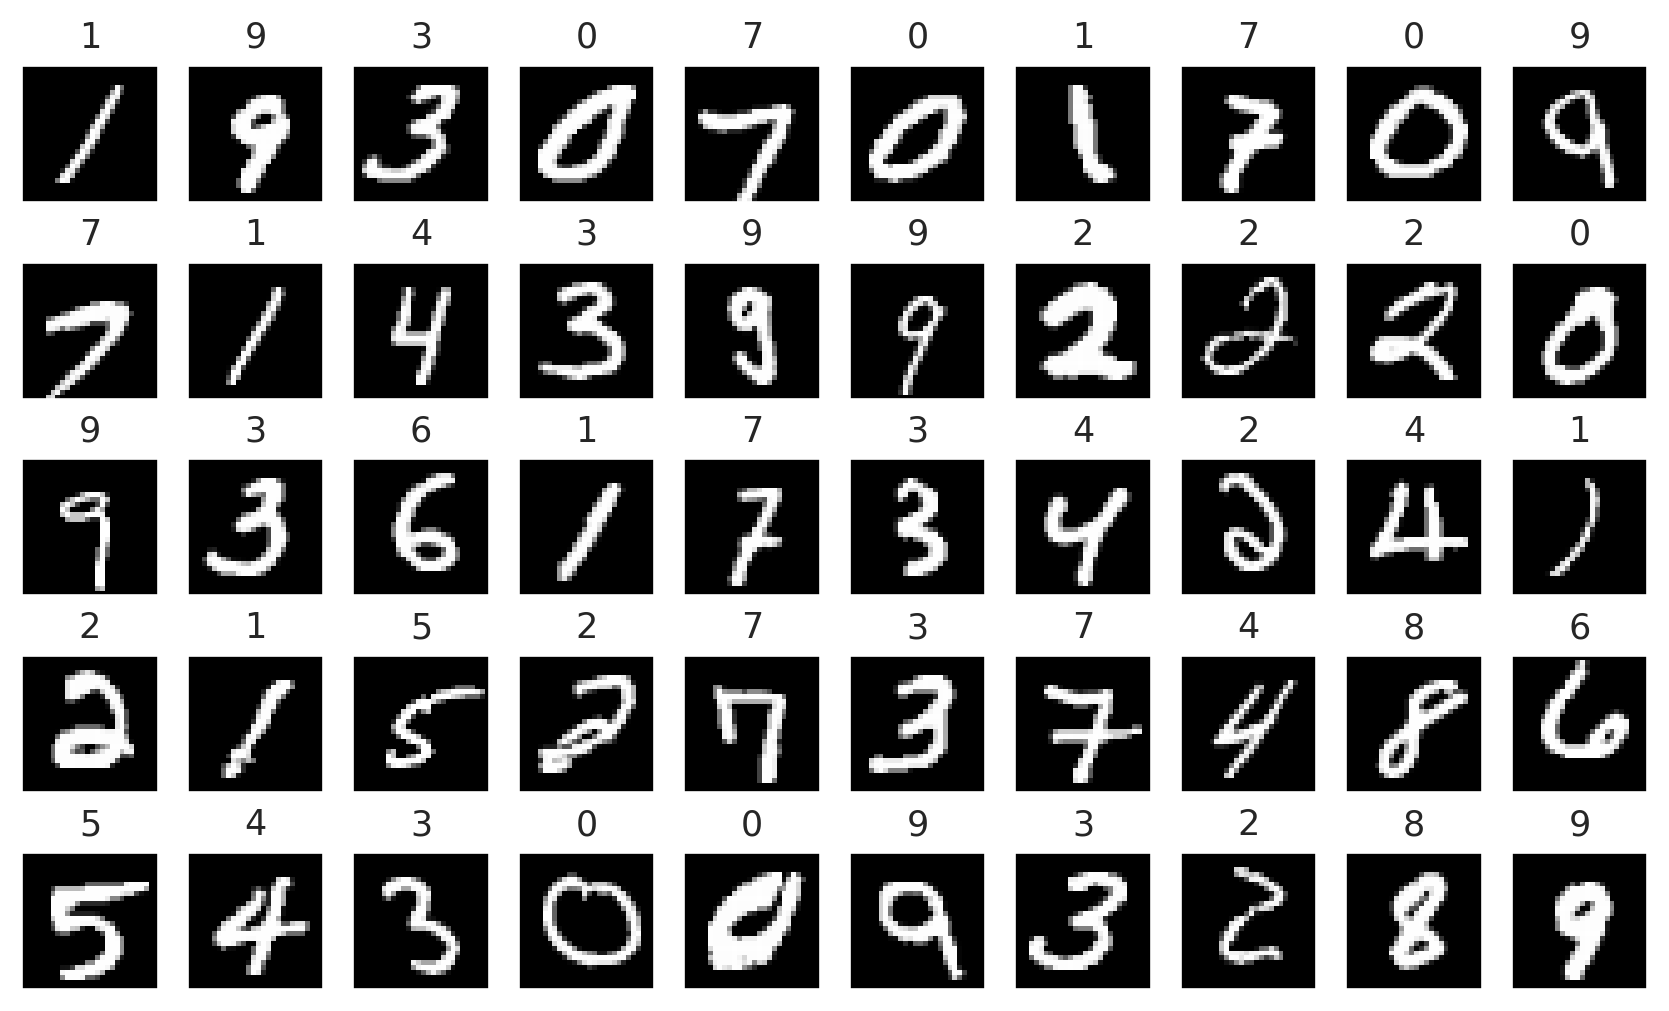

In [42]:
perm = np.random.permutation(range(X_mnist.shape[0]))[0:50]

random_imgs   = X_mnist[perm]
random_labels = y_mnist[perm] 

fig = plt.figure(figsize=(10,6))
for i in range(random_imgs.shape[0]):
    ax=fig.add_subplot(5,10,i+1)
    plt.imshow(random_imgs[i].reshape(28,28), interpolation="nearest", cmap = plt.cm.Greys_r)
    ax.set_title(int(random_labels[i]))
    plt.xticks([]); plt.yticks([])

A continuación, graficamos la curva acumulativa de la varianza explicada versus el número de componentes principales:

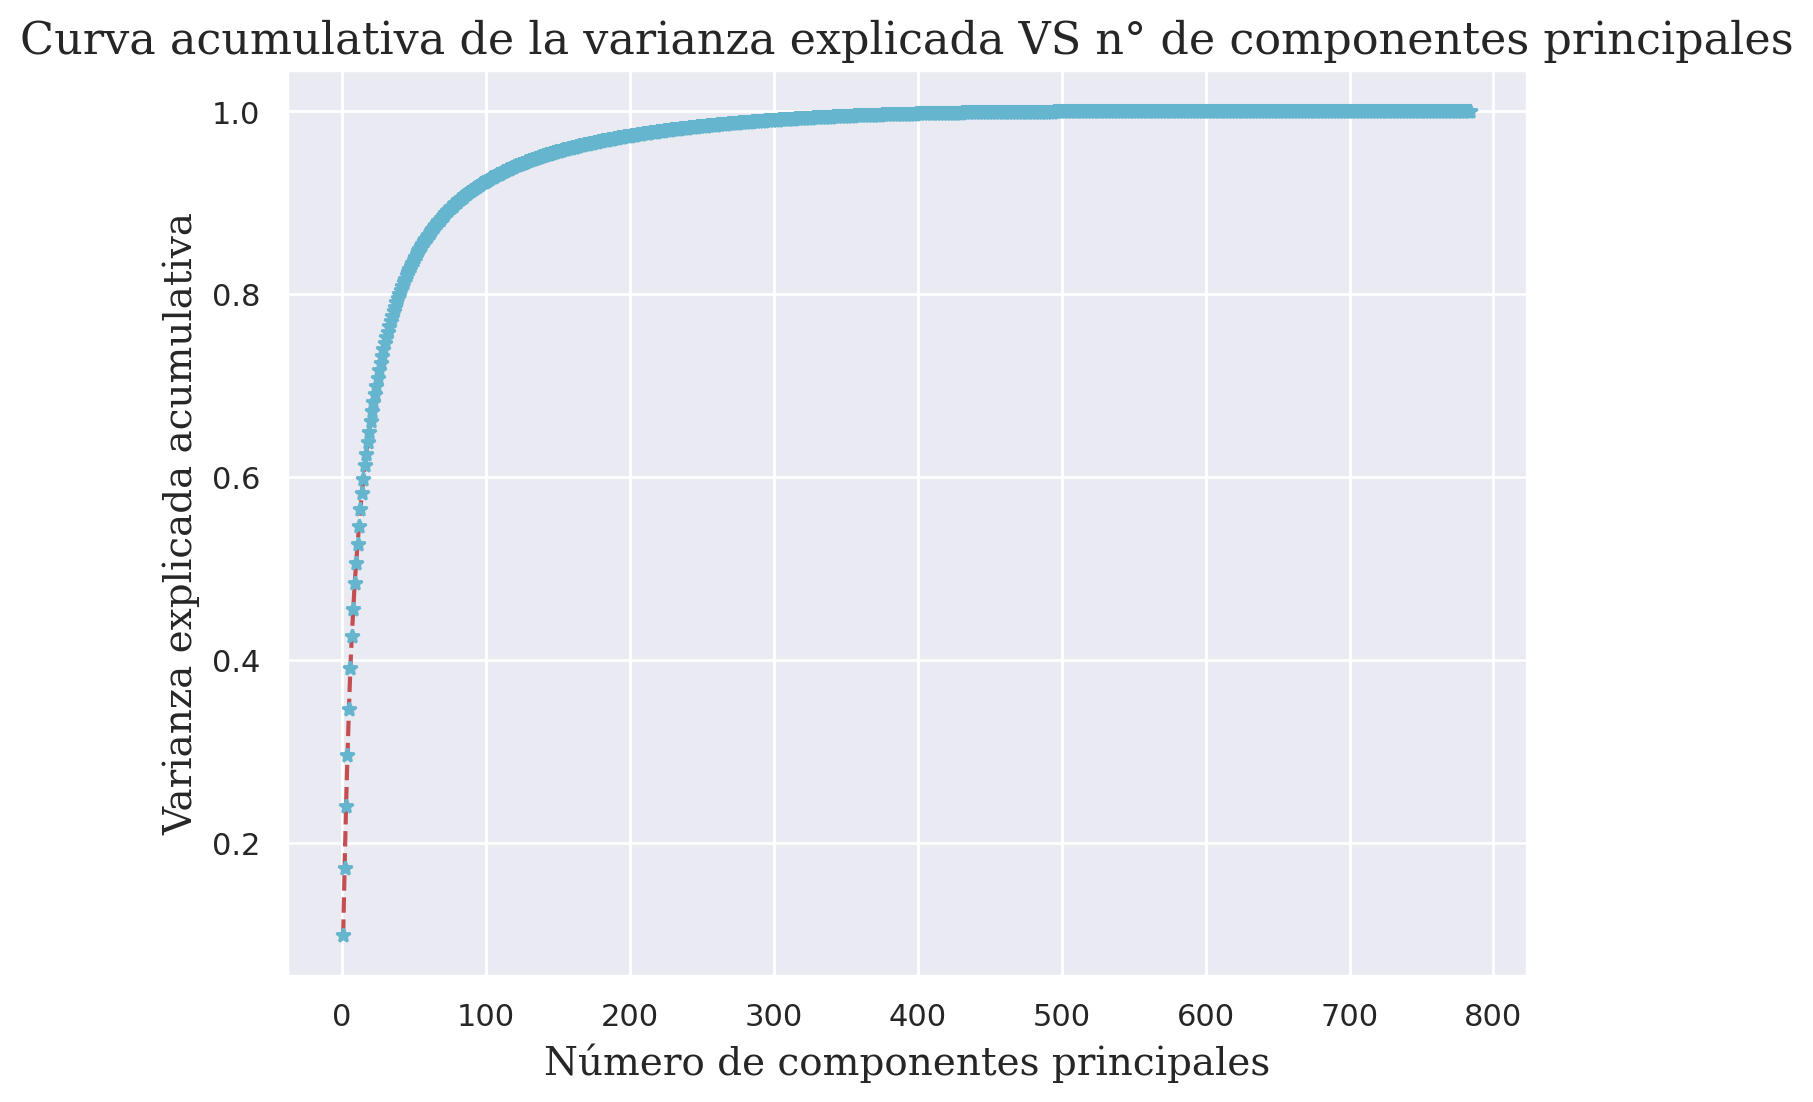

In [43]:
# PCA en MNIST
pca = PCA(n_components=None)
X_mnist_transf = pca.fit_transform(X_mnist)
varianza_expl = pca.explained_variance_ratio_

cum_var_exp = np.cumsum(varianza_expl)

cumulative_explained_variance_plot(varianza_expl)

In [44]:
print(f'Primeras 10 componentes: {cum_var_exp[9]}')
print(f'Primeras 60 componentes: {cum_var_exp[59]}')
print(f'Primeras 100 componentes: {cum_var_exp[99]}')

Primeras 10 componentes: 0.5056960927862708
Primeras 60 componentes: 0.8647193170475653
Primeras 100 componentes: 0.9240264727402193


Podemos observar lo siguiente:
  * Las $10$ primeras componentes principales representan el $50,6\%$ de la varianza de los datos
  * Las $60$ primeras componentes principales representan el $86,5\%$ de la varianza de los datos
  * Las $100$ primeras componentes principales representan el $92,4\%$ de la varianza de los datos

A continuación, usamos las primeras $10$ componentes principales y graficaremos la transformación inversa:

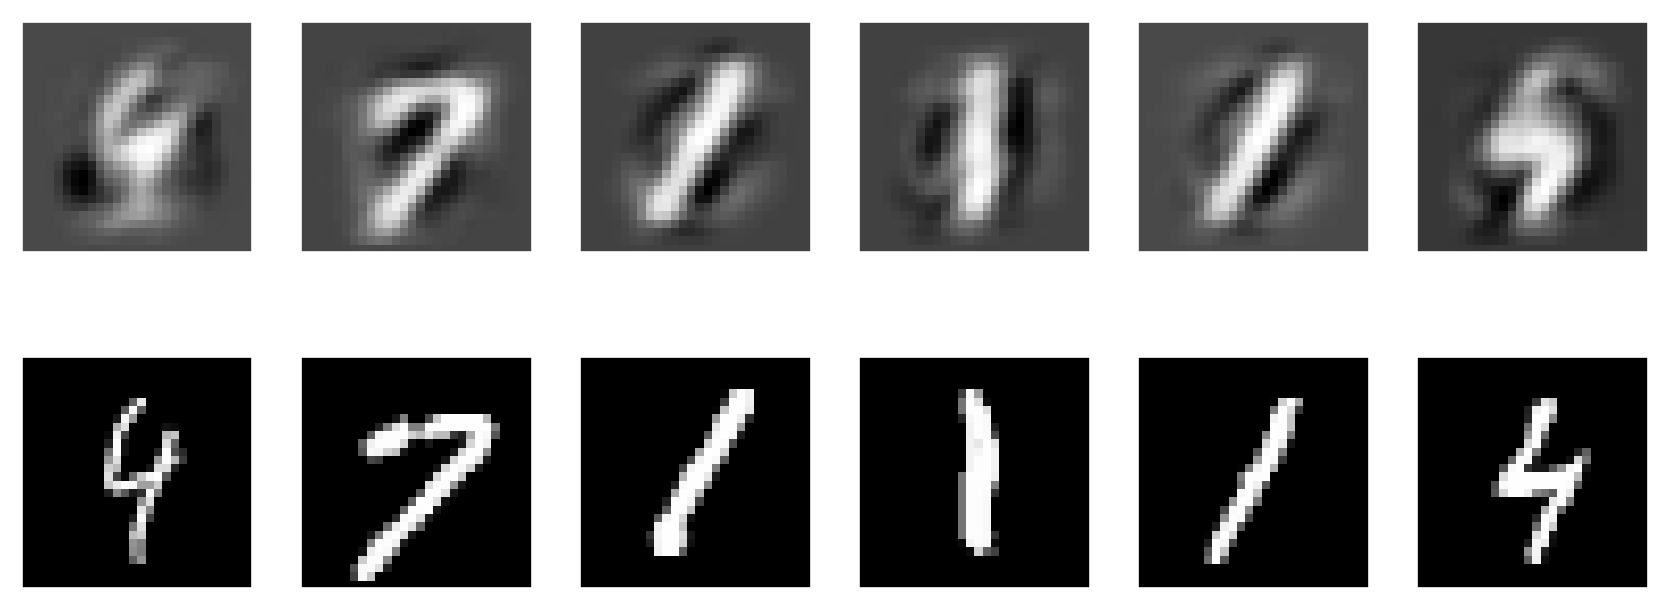

In [45]:
pca = PCA(n_components=10)
Xp = pca.fit_transform(X_mnist)
Xr = pca.inverse_transform(Xp)

show_img_matrix_pca(X_mnist, Xr)

Los datos reconstruidos se asemejan bastante a los datos originales. Un proceso similar es el realizado en la [compresión de imágenes](https://en.wikipedia.org/wiki/Image_compression), en el cual se conserva la información más relevante y  necesaria para que sea reconocible. 
Ahora usemos las primeras $60$ componentes principales:

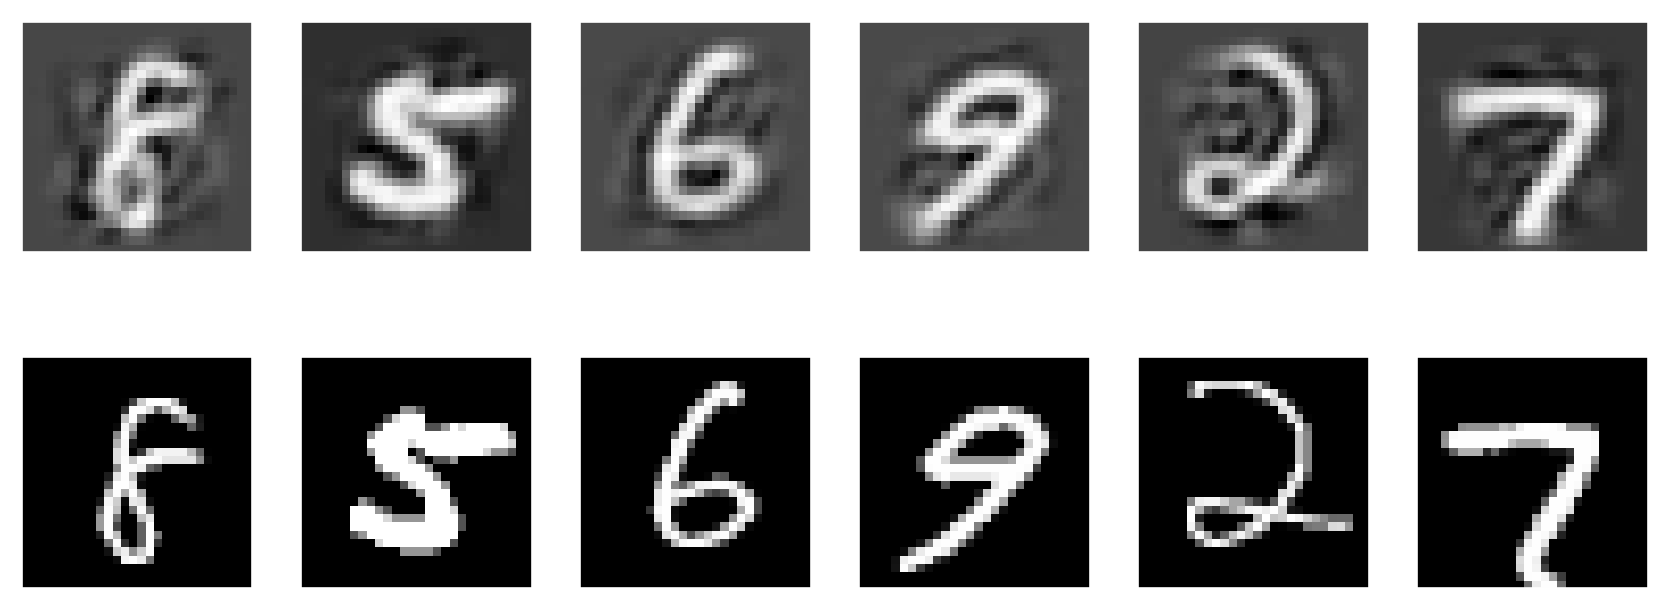

In [46]:
pca = PCA(n_components=60)
Xp = pca.fit_transform(X_mnist)
Xr = pca.inverse_transform(Xp)

show_img_matrix_pca(X_mnist, Xr)

Y con las primeras $100$ componentes principales:

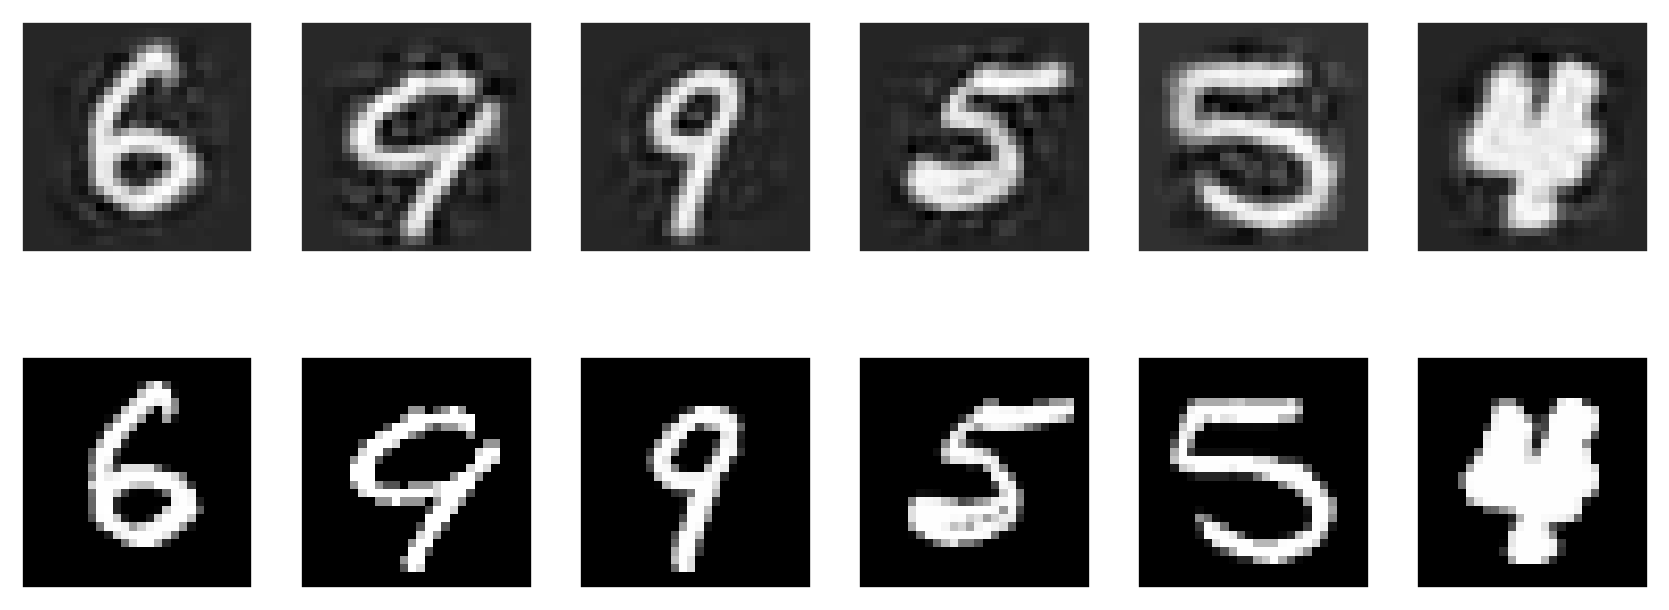

In [47]:
pca = PCA(n_components=100)
Xp = pca.fit_transform(X_mnist)
Xr = pca.inverse_transform(Xp)

show_img_matrix_pca(X_mnist, Xr)


Los datos resultantes no están organizados como en los pixeles de una imágen, sino que corresponden a la codificación numérica de la información más importante con menos dimensiones.

In [48]:
print(Xr[0,:5])

[-2.50226367e-14  5.49796751e-14 -7.91610142e-14  9.30666630e-14
  1.80758904e-14]


Finalmente, realicemos el proceso de modelado de clasificación de las imágenes, y comparemos los resultados entre las dos opciones. En este caso usaremos un clasificador bayesiano con el método **`sklearn.naive_bayes.GaussianNB`**.

Los clasificadores *Naive Bayes* están basados en métodos de clasificación bayesiana y en el teorema de *Bayes*, que describe la relación de las probabilidades condicionales de cantidades estadísticas. Este método funciona de forma similar a los demás clasificadores vistos en el curso.

Veamos la efectividad de este modelo tanto para los datos originales como para la nueva representación obtenida con _PCA_.

In [49]:
# Selección de modelos y validación cruzada.
from sklearn.model_selection import cross_val_score

# Métodos de modelado - Clasificación con NaiveBayes Gaussiano.
from sklearn.naive_bayes import GaussianNB

print(f"Accuracy con datos originales: {np.mean(cross_val_score(GaussianNB(), X_mnist, y_mnist, cv=5)):.4f}")
print(f"Accuracy con la nueva representación: {np.mean(cross_val_score(GaussianNB(), Xp, y_mnist, cv=5)):.4f}")

Accuracy con datos originales: 0.5680
Accuracy con la nueva representación: 0.8093


Podemos notar que al usar los datos de entrenamiento reducidos obtenemos una mayor precisión o *accuracy* promedio que al usar todos los datos originales.

# **Recursos adicionales**
---
Los siguientes enlaces corresponden a sitios en donde encontrará información muy útil para profundizar en el conocimiento de las funcionalidades de la librería *Scikit-learn* en la aplicación de técnicas de reducción de la dimensionalidad y análisis de componentes principales, además de material de apoyo teórico para reforzar estos conceptos:

* **Introductorios**
  * [A One-Stop Shop for Principal Component Analysis - Matt Brems](https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c)
  * [PCA example with Iris Data-set](https://scikit-learn.org/stable/auto_examples/decomposition/plot_pca_iris.html#sphx-glr-auto-examples-decomposition-plot-pca-iris-py)
  * [Manifold Hypothesis - Deep AI glossary](https://deepai.org/machine-learning-glossary-and-terms/manifold-hypothesis)
  * [Dimensionality Reduction, PCA Intro - AI Pool](https://ai-pool.com/a/s/dimensionality-reduction--pca-intro)
  * [Principal component analysis explained simply - BioTuring's Blog](https://blog.bioturing.com/2018/06/14/principal-component-analysis-explained-simply/)

* **Avanzados**
  * [Mathematics For Machine Learning Chapter 10 - Dimensionality Reduction with Principal Component Analysis](https://mml-book.github.io/book/mml-book.pdf)

  * [John Shlens - A Tutorial on Principal Component Analysis](https://www.cs.princeton.edu/picasso/mats/PCA-Tutorial-Intuition_jp.pdf)


# **Créditos**
---

* **Profesor:** [Fabio Augusto Gonzalez](https://dis.unal.edu.co/~fgonza/)
* **Asistentes docentes:** 
  * Miguel Angel Ortiz Marín
  * Alberto Nicolai Romero Martínez

**Universidad Nacional de Colombia** - *Facultad de Ingeniería*